In [2]:
import numpy as np
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Normalize
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader

In [3]:
batch_size = 64
epochs = 10

# Data processing

In [4]:
train_dataset = MNIST(root='data', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='data', train=False, transform=ToTensor(), download=True)

Let's take a look at the dataset

Image has label: 3
Shape of the img in dataset: torch.Size([1, 28, 28])


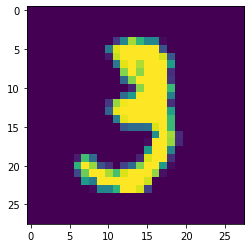

In [5]:
img, label = train_dataset[10]
img = ToPILImage()(img)
print(f"Image has label: {label}")
print(f"Shape of the img in dataset: {train_dataset[0][0].shape}")
plt.imshow(img)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size)

# Model structure

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3), nn.BatchNorm2d(32), nn.PReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=3), nn.BatchNorm2d(64), nn.PReLU(), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=3), nn.BatchNorm2d(64), nn.PReLU())
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(nn.Linear(12544, 2048), nn.PReLU(), nn.Linear(2048, 256), nn.PReLU(), nn.Dropout(), nn.Linear(256, 10))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.linear(x)
        logits = self.softmax(x)

        return x

# Training module

In [18]:
def train(model, dataloader, optimizer, loss_fn):
    best_loss = 1000
    for epoch in range(epochs):
        avg_loss = 0
        print(f"======= Epoch {epoch+1} =======")
        size = len(dataloader.dataset)
        model.train()

        for batch, (img, label) in enumerate(dataloader):
            if batch <= 936:
                pred = model(img)
                loss = loss_fn(pred, label)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if batch % 100 == 0:
                    loss, current = loss.item(), batch * len(img)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                    avg_loss += loss
        avg_loss /= 10
        print(f"Average loss on the epoch {epoch+1}: {avg_loss:>7f}")
        if avg_loss >= best_loss * 1.1:
            break
        best_loss = min(best_loss, avg_loss)
    torch.save(model.state_dict(), 'model_weights.pth')
    print(f"The model with the best loss({best_loss}) has been saved.")

In [19]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [20]:
train(model, train_dataloader, optimizer, loss_fn)

======= Epoch 1 =======
loss: 2.314101  [    0/60000]
loss: 0.152175  [ 6400/60000]
loss: 0.131183  [12800/60000]
loss: 0.049104  [19200/60000]
loss: 0.139492  [25600/60000]
loss: 0.116373  [32000/60000]
loss: 0.091498  [38400/60000]
loss: 0.058595  [44800/60000]
loss: 0.027748  [51200/60000]
loss: 0.031674  [57600/60000]
Average loss on the epoch 1: 0.311194
======= Epoch 2 =======
loss: 0.032532  [    0/60000]
loss: 0.110173  [ 6400/60000]
loss: 0.032906  [12800/60000]
loss: 0.111668  [19200/60000]
loss: 0.013076  [25600/60000]
loss: 0.223117  [32000/60000]
loss: 0.014135  [38400/60000]
loss: 0.043407  [44800/60000]
loss: 0.046399  [51200/60000]
loss: 0.059730  [57600/60000]
Average loss on the epoch 2: 0.068714
======= Epoch 3 =======
loss: 0.004017  [    0/60000]
loss: 0.020048  [ 6400/60000]
loss: 0.006699  [12800/60000]
loss: 0.058302  [19200/60000]
loss: 0.086906  [25600/60000]
loss: 0.086484  [32000/60000]
loss: 0.034257  [38400/60000]
loss: 0.008417  [44800/60000]
loss: 0.1827

In [122]:
len(train_dataset)

60000

# Testing the model

In [24]:
def test(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)-1
    test_loss, correct = 0, 0

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i <= 155:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
test(model, test_dataloader, loss_fn)

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.045296 

